# LSTM - Aula TCDF 27/08/21

Esse notebook é um guia para utilização de LSTMs em tarefas de classificação de textos. O código foi preparado por Matheus Stauffer Viana de Oliveira, aluno do curso de Licenciatura em Computação da Universidade de Brasília, em conjunto com o professor Dr. Thiago Faleiros. Ambos os autores são membros do projeto [KnEDLe](http://nido.unb.br/).

Alguns links de recursos de referência para esse trabalho são os seguintes:
- https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
- https://medium.com/towards-artificial-intelligence/keras-for-multi-label-text-classification-86d194311d0e
- https://www.youtube.com/watch?v=j7EB7yeySDw
- https://medium.com/swlh/multi-label-text-classification-with-scikit-learn-and-tensorflow-257f9ee30536
- https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
- https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

## Import dos dados

Lidaremos com dados armazenados em repositório do GitHub. Para tanto, precisamos clonar o repositório para a sessão corrente do Colab:

In [1]:
!git clone -l -s git://github.com/mstauffer/tcdf_text_classification.git

Cloning into 'tcdf_text_classification'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 4), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (18/18), 439.71 KiB | 4.53 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## Dados de atos de pessoal do DODF

Esse conjunto de dados é uma iniciativa do projeto de pesquisa [KnEDLe](http://nido.unb.br/) e está em fase final de elaboração. Os dados foram anotados manualmente pelos membros do projeto e também por voluntários. A revisão e curadoria dos dados ficou à cargo da equipe de anotação do projeto de pesquisa. A tarefa de classificação proposta aqui é, dado um texto de um ato de pessoal de entrada, prever qual é o tipo desse ato.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/tcdf_text_classification/dodf_atos.csv')
df

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto
0,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,nome,3537,carlos_gabriel,197948,23,YURI MACHADO DE MENEZES
1,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,matricula,3538,carlos_gabriel,197983,8,61.836-5
2,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,vigencia,3539,carlos_gabriel,198021,22,12 de setembro de 2008
3,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,Ato_Reversao,3540,carlos_gabriel,197866,178,REVERTER o REGIME DE TEMPO INTEGRAL E DEDICACA...
4,87_118.20.6.8,Ato_Nomeacao_Comissionado,R1,lygia_paloma,nome,1583,lygia_paloma,212316,28,JOAO PAULO PATROCINA MARQUES
...,...,...,...,...,...,...,...,...,...,...
20750,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,matricula_substituido,8685,vinicius_borges,644324,9,174.833-5
20751,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,data_inicial,8686,vinicius_borges,644348,2,09
20752,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,data_final,8687,vinicius_borges,644353,10,11/10/2013
20753,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,motivo,8688,vinicius_borges,644380,32,ferias regulamentares da titular


In [3]:
df_atos = df.loc[df.iloc[:,4].str.contains('Ato')]
df_atos

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto
3,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,Ato_Reversao,3540,carlos_gabriel,197866,178,REVERTER o REGIME DE TEMPO INTEGRAL E DEDICACA...
9,87_118.20.6.8,Ato_Nomeacao_Comissionado,R1,lygia_paloma,Ato_Nomeacao_Comissionado,1588,lygia_paloma,212309,316,NOMEAR JOAO PAULO PATROCINA MARQUES para exerc...
10,17_133.28.6.2013,Ato_Exoneracao_Comissionado,R3,matheus_stauffer,Ato_Exoneracao_Comissionado,1178,pedro_henrique,205008,326,EXONERAR SEBASTIAO FRANCISCO DE QUEIROZ do Car...
19,17_133.28.6.2013,Ato_Exoneracao_Comissionado,R5,matheus_stauffer,Ato_Exoneracao_Comissionado,2354,pedro_henrique,205008,326,EXONERAR SEBASTIAO FRANCISCO DE QUEIROZ do Car...
28,17_133.28.6.2013,Ato_Exoneracao_Comissionado,R7,matheus_stauffer,Ato_Exoneracao_Comissionado,3530,pedro_henrique,205008,326,EXONERAR SEBASTIAO FRANCISCO DE QUEIROZ do Car...
...,...,...,...,...,...,...,...,...,...,...
20699,13_212.10.10.2013,Ato_Retificacao_Efetivo,R70,jose_reinaldo,Ato_Retificacao_Efetivo,6419,jose_reinaldo,599784,311,"Na Ordem de Servico de 24/07/2013, publicada n..."
20710,13_212.10.10.2013,Ato_Retificacao_Efetivo,R71,jose_reinaldo,Ato_Retificacao_Efetivo,6431,jose_reinaldo,600097,447,"Na Ordem de Servico de 02/04/2012, publicada n..."
20729,13_212.10.10.2013,Ato_Retificacao_Efetivo,R72,jose_reinaldo,Ato_Retificacao_Efetivo,6445,jose_reinaldo,600546,294,"Na Ordem de Servico de 24/07/2013, publicada n..."
20734,13_212.10.10.2013,Ato_Retificacao_Efetivo,R73,jose_reinaldo,Ato_Retificacao_Efetivo,6487,vinicius_borges,624445,487,RETIFICAR na Portaria de 1o de outubro de 2013...


Gerando um dicionário que mapeia tipos de ato para valores inteiros e adicionando ao dataframe.

In [4]:
labels_unique = df_atos.tipo_ent.unique().tolist()
labels_unique_dict = {}
for index, possible_label in enumerate(labels_unique):
    labels_unique_dict[possible_label] = index
labels_unique_dict

{'Ato_Abono_Permanencia': 8,
 'Ato_Cessao': 5,
 'Ato_Exoneracao_Comissionado': 2,
 'Ato_Exoneracao_Efetivo': 9,
 'Ato_Nomeacao_Comissionado': 1,
 'Ato_Nomeacao_Efetivo': 7,
 'Ato_Retificacao_Comissionado': 10,
 'Ato_Retificacao_Efetivo': 6,
 'Ato_Reversao': 0,
 'Ato_Substituicao': 4,
 'Ato_Tornado_Sem_Efeito_Apo': 11,
 'Ato_Tornado_Sem_Efeito_Exo_Nom': 3}

In [5]:
df_atos['label_int'] = df_atos['tipo_ent'].replace(labels_unique_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Aqui entidades numéricas, capitalização e pontuação podem ser importantes. Por isso, não iremos fazer a etapa de pré-processamento que normalmente é feita.

### LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

#### Train Test Split

O split será estratificado em relação aos labels.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_atos['texto'], df_atos['label_int'], test_size=0.25, random_state=14, stratify=df_atos['label_int'])

Os modelos da API do Keras requerem como entrada tensores ou arrays numpy.

In [8]:
train_labels = np.array(y_train)
test_labels = np.array(y_test)

In [9]:
train_labels.shape

(1696,)

In [10]:
len(X_train), len(X_test)

(1696, 566)

#### Modificando os dados de treino e teste com o padrão requerido pelo Keras

In [11]:
soma = 0

for item in df_atos['texto']:
  soma += len(item)
media = soma/len(df_atos['texto'])
print(f'Em média, cada ato de pessoal tem {media} palavras.')

Em média, cada ato de pessoal tem 353.0344827586207 palavras.


Aqui definimos algumas constantes usadas a seguir. `vocab_size` se refere à quantidade de palavras que serão levadas em consideração durante o treinamento; `embedding_dim` se refere à quantidade de neurônios da camada de embedding da nossa rede recorrente; `max_length` é a quantidade máxima de palavras usadas para as instâncias de treinamento. Vamos setar um valor menor que a média de palavras por ato. `trunc_type` e `padding_type` se referem ao método de pré-processamento `pad_sequences`; o primeiro define se o pad é feito antes ou depois de cada sequência de textos, o segundo remove valores maiores que o max_length setado. Por fim, `oov_tok` é o padrão adotado para palavras desconhecidas.

In [12]:
vocab_size = 1000 # make the top list of words (common words)
embedding_dim = 64
max_length = 64
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

O método `fit_on_texts` do objeto `Tokenizer` mapeia cada palavra única com um inteiro.

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

A propriedade `word_index` mostra o índice de cada palavra processada. Com ela também podemos ver o tamanho do nosso vocabulário:

In [14]:
word_index = tokenizer.word_index

In [15]:
len(word_index)

4574

In [16]:
word_index

{'<OOV>': 1,
 'de': 2,
 'da': 3,
 'do': 4,
 'no': 5,
 'a': 6,
 'cargo': 7,
 'federal': 8,
 'distrito': 9,
 'o': 10,
 'para': 11,
 'simbolo': 12,
 'e': 13,
 'em': 14,
 'matricula': 15,
 'secretaria': 16,
 'estado': 17,
 '2013': 18,
 'comissao': 19,
 'saude': 20,
 'exercer': 21,
 'se': 22,
 'diretoria': 23,
 'nomear': 24,
 'subsecretaria': 25,
 'por': 26,
 'dodf': 27,
 'gerencia': 28,
 'administracao': 29,
 '07': 30,
 'que': 31,
 'dfa': 32,
 'na': 33,
 'exonerar': 34,
 'pagina': 35,
 'assessor': 36,
 'dfg': 37,
 'geral': 38,
 'regional': 39,
 '06': 40,
 '12': 41,
 'especial': 42,
 '14': 43,
 'civil': 44,
 '1': 45,
 '05': 46,
 'coordenadoria': 47,
 '10': 48,
 'silva': 49,
 '11': 50,
 'casa': 51,
 'ato': 52,
 'le': 53,
 'onde': 54,
 'leia': 55,
 'governadoria': 56,
 'das': 57,
 'tecnico': 58,
 'com': 59,
 'cne': 60,
 'quinquenio': 61,
 'decreto': 62,
 'cidades': 63,
 'coordenacao': 64,
 '08': 65,
 '04': 66,
 '09': 67,
 'publicada': 68,
 'lei': 69,
 'natureza': 70,
 'chefe': 71,
 'maria': 7

O método `texts_to_sequences` converte uma entrada de texto em uma lista de inteiros via a prop `word_index` criada anteriormente. A função `pad_sequences` adiciona um padding a cada entrada para garantir que todas as sequências tenham o mesmo tamanho.

In [17]:
train_sequences = tokenizer.texts_to_sequences(X_train)

In [18]:
len(train_sequences[0])

62

In [19]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
len(train_padded[0])

64

In [21]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [22]:
train_padded.shape, test_padded.shape

((1696, 64), (566, 64))

In [23]:
print(X_train.iloc[0])
print(train_sequences[0])

Na Ordem de Servico de 18/06/2002, da Gerencia de Cadastro de Registro, publicada no DODF 
no 117, de 21/06/2002, pagina 21, que concedeu Licenca-Premio por Assiduidade a MARINA 
RODRIGUES FERNANDES, matricula 54.470-1, ONDE SE LE: 4o quinquenio: 01/03/1997 
a 28/02/2002, LEIA-SE: 4o quinquenio: 14/05/1997 a 13/05/2002.
[33, 82, 2, 78, 2, 152, 40, 187, 3, 28, 2, 175, 2, 182, 68, 5, 27, 5, 1, 2, 141, 40, 187, 35, 141, 31, 84, 77, 80, 26, 98, 6, 1, 192, 378, 15, 562, 715, 45, 54, 22, 53, 176, 61, 73, 74, 208, 6, 165, 81, 187, 55, 22, 176, 61, 43, 46, 208, 6, 110, 46, 187]


#### Instanciando o modelo

In [24]:
classes = set(labels_unique_dict)
classes

{'Ato_Abono_Permanencia',
 'Ato_Cessao',
 'Ato_Exoneracao_Comissionado',
 'Ato_Exoneracao_Efetivo',
 'Ato_Nomeacao_Comissionado',
 'Ato_Nomeacao_Efetivo',
 'Ato_Retificacao_Comissionado',
 'Ato_Retificacao_Efetivo',
 'Ato_Reversao',
 'Ato_Substituicao',
 'Ato_Tornado_Sem_Efeito_Apo',
 'Ato_Tornado_Sem_Efeito_Exo_Nom'}

In [25]:
num_classes = len(classes)

Começamos com uma camada de embedding, que recebe os índices de inteiros e os transforma em vetores de palavras. É importante que `input_length` corresponda com o tamanho dos dados - mais cedo setamos como `max_length` 64 tokens. Em seguida, temos a primeira camada LSTM, com uma saída de dimensionalidade de 128. Adicionamos uma camada de Dropout. De acordo com a documentação do Keras, essa camada 'aleatoriamente seta unidades de entrada com 0, com frequência de ocorrência indicada como parâmetro em cada passo do treinamento, o que previne overfitting'. Nós então repetimos essa combinação, com a camada LSTM recebendo metade das unidades de entrada em relação à combinação anterior. Por último, adicionamos uma camada Dense, que implementa a função de ativação. O primeiro parâmetro aqui se refere à dimensionalidade da saída.

- Embedding ref: https://keras.io/api/layers/core_layers/embedding/
- LSTM ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- Dropout ref: https://keras.io/api/layers/regularization_layers/dropout/
- Dense ref: https://keras.io/api/layers/core_layers/dense/.

In [47]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim=64, input_length=64))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 64)            64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                396       
Total params: 109,836
Trainable params: 109,836
Non-trainable params: 0
________________________________________________

A função de loss usada é a `sparse_categorical_crossentropy`. Ela é a mais indicada para cenários multiclasse.

Ref: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [49]:
train_padded[0]

array([ 33,  82,   2,  78,   2, 152,  40, 187,   3,  28,   2, 175,   2,
       182,  68,   5,  27,   5,   1,   2, 141,  40, 187,  35, 141,  31,
        84,  77,  80,  26,  98,   6,   1, 192, 378,  15, 562, 715,  45,
        54,  22,  53, 176,  61,  73,  74, 208,   6, 165,  81, 187,  55,
        22, 176,  61,  43,  46, 208,   6, 110,  46, 187,   0,   0],
      dtype=int32)

In [50]:
train_labels[0]

10

In [51]:
train_padded.shape, train_labels.shape

((1696, 64), (1696,))

#### Fit no modelo

In [52]:
history = model.fit(train_padded, train_labels, epochs=15, validation_data=(test_padded, test_labels))

Epoch 1/15
53/53 [==============================] - 6s 56ms/step - loss: 1.9038 - accuracy: 0.3290 - val_loss: 1.3810 - val_accuracy: 0.5353
Epoch 2/15
53/53 [==============================] - 2s 38ms/step - loss: 1.3131 - accuracy: 0.4894 - val_loss: 1.0189 - val_accuracy: 0.5866
Epoch 3/15
53/53 [==============================] - 2s 38ms/step - loss: 0.9950 - accuracy: 0.6226 - val_loss: 0.7707 - val_accuracy: 0.7597
Epoch 4/15
53/53 [==============================] - 2s 37ms/step - loss: 0.7387 - accuracy: 0.7789 - val_loss: 0.4989 - val_accuracy: 0.8233
Epoch 5/15
53/53 [==============================] - 2s 37ms/step - loss: 0.5248 - accuracy: 0.8414 - val_loss: 0.4080 - val_accuracy: 0.8587
Epoch 6/15
53/53 [==============================] - 2s 37ms/step - loss: 0.4451 - accuracy: 0.8585 - val_loss: 0.3353 - val_accuracy: 0.8799
Epoch 7/15
53/53 [==============================] - 2s 38ms/step - loss: 0.4465 - accuracy: 0.8667 - val_loss: 0.3974 - val_accuracy: 0.8481
Epoch 8/15
53

Plot do ajuste do modelo conforme épocas rodadas:

In [32]:
# https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=en

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.9901136368513108)

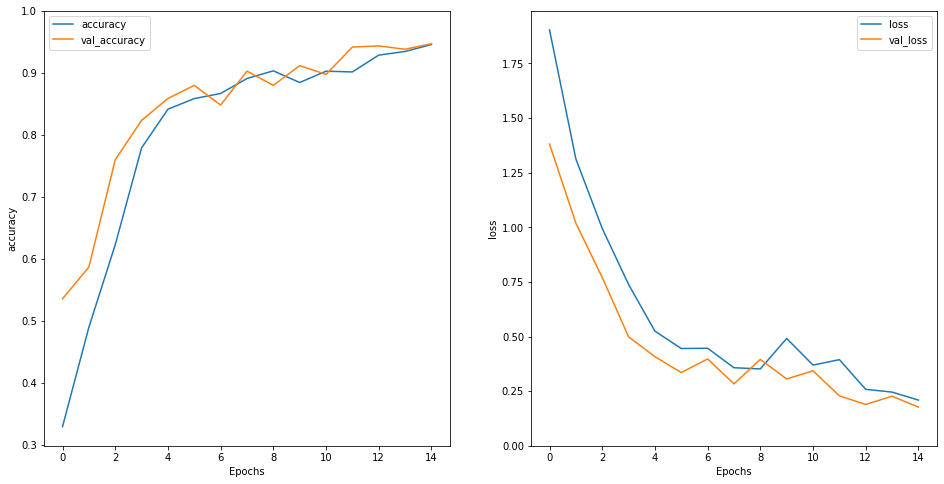

In [53]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Vimos a acurácia, mas vamos checar a perspectiva de outras métricas:

In [54]:
# evaluate the model
_, test_acc = model.evaluate(test_padded, test_labels, verbose=0)

In [55]:
print(test_acc)

0.9469964504241943


Obtendo vetor de predições no conjunto de teste. Note que usamos um batch_size de 50 (12 * 50 = 600).

In [56]:
y_pred_lstm = model.predict(test_padded, batch_size=50, verbose=2)

12/12 - 1s


Nosso vetor tem dimensionalidade de 566 instâncias do conjunto de teste, com 12 valores representando probabilidades de pertencimento à cada classe (saída da camada Dense).

In [57]:
y_pred_lstm.shape

(566, 12)

Queremos um vetor que represente a classe predita em cada instância, isto é, a classe de maior probabilidade do vetor `y_pred_lstm`. Fazemos isso usando o `argmax` do numpy.

In [58]:
index_array = np.argmax(y_pred_lstm, axis=-1)
len(index_array)

566

Agora podemos calcular facilmente Precisão, Recall e F1 Score usando o `precision_recall_fscore_support` do Sklearn.

In [59]:
from sklearn.metrics import precision_recall_fscore_support

results = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'support']
          )
results.loc['LSTM'] = precision_recall_fscore_support(
          y_test, 
          index_array, 
          average = 'weighted'
          )

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
results

,Precision,Recall,F1 score,support
LSTM,0.929525,0.946996,0.936449,NaN


### Baseline TFIDF + SVM e Regressão Logística


Encode TFIDF:

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# fit_transform no treino
X_csr_train = vectorizer.fit_transform(X_train)
print(X_csr_train.shape)

# apenas transform no teste
X_csr_test = vectorizer.transform(X_test)
print(X_csr_test.shape)

(1696, 4548)
(566, 4548)


Aplicação nos modelos com hiperparâmetros padrão:

In [42]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [43]:
svm_model = LinearSVC(max_iter=1000, random_state=14, verbose=True)
svm_model.fit(X_csr_train, y_train)
svm_prediction_tfidf = svm_model.predict(X_csr_test)

[LibLinear]

In [44]:
tfidf_logreg = LogisticRegression(max_iter=1000, random_state=14, verbose=True)
tfidf_logreg.fit(X_csr_train, y_train)
y_pred_tfidf_reg = tfidf_logreg.predict(X_csr_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [62]:
results = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'support']
          )
results.loc['LSTM'] = precision_recall_fscore_support(
          y_test, 
          index_array, 
          average = 'weighted'
          )
results.loc['TFIDF + LogReg'] = precision_recall_fscore_support(
          y_test, 
          y_pred_tfidf_reg, 
          average = 'weighted'
          )
results.loc['TFIDF + SVM'] = precision_recall_fscore_support(
          y_test, 
          svm_prediction_tfidf, 
          average = 'weighted'
          )

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
results

,Precision,Recall,F1 score,support
LSTM,0.929525,0.946996,0.936449,NaN
TFIDF + LogReg,0.956668,0.962898,0.958400,NaN
TFIDF + SVM,0.989392,0.989399,0.989362,NaN


Aqui os baselines vão melhor!

A combinação TFIDF + SVM teve o melhor score - sem busca de hiperparâmetros, diga-se de passagem - rodando em CPU, com um custo computacional muito menor. Possivelmente explorando outras opções de arquitetura para a rede ou tamanho da entrada para a camada LSTM, poderíamos obter um score melhor. A análise do tradeoff entre performance e custo-benefício depende muito do tipo de aplicação; aqui o baseline soa mais adequado.